# **Imports and Installs**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
#import preprocessor as p
import re
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import string
import html
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import os
import pickle
from sklearn.metrics import classification_report, accuracy_score
from google.colab import files
import io

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
!pip install preprocessor
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4473 sha256=07ac72d1981710e0b790d7dbf4f6f1ac9034e2da20bc749cbe99c230adcfafa6
  Stored in directory: /root/.cache/pip/wheels/18/41/3e/30e0c08b0759166f31aee174d58d288ad5c277bd102c8ad869
Successfully built preprocessor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tweet Preprocessing**

In [8]:
df_ukraine_jan = pd.read_csv("/content/drive/MyDrive/Datasets/tweet_ukraine_jan.csv")
df_ukraine_feb = pd.read_csv("/content/drive/MyDrive/Datasets/tweet_ukraine_feb.csv")
df_ukraine_mar = pd.read_csv("/content/drive/MyDrive/Datasets/tweet_ukraine_apr.csv")

In [9]:
col = ["Unnamed:0", "ID", "Date", "Tweet"]
df_ukraine = pd.DataFrame(columns=col)

df_ukraine = pd.concat([df_ukraine, df_ukraine_jan])
df_ukraine = pd.concat([df_ukraine, df_ukraine_feb])
df_ukraine = pd.concat([df_ukraine, df_ukraine_mar])

In [10]:
def clean_text(_sentence):

    #removes emojis, pictographs, map symbols and flags
    emoji_pattern = re.compile(pattern = "["
          u"\U0001F600-\U0001F64F" 
          u"\U0001F300-\U0001F5FF" 
          u"\U0001F680-\U0001F6FF" 
          u"\U0001F1E0-\U0001F1FF" 
                            "]+", flags = re.UNICODE)
    _sentence = emoji_pattern.sub(r'',_sentence)

    #emoves tags and attributes
    _sentence = re.sub('(<[^>]*>)','',_sentence)

    #converts character code to string
    _sentence = html.unescape(_sentence)

    #removes urls
    _sentence = re.sub("(\w+:\/\/\S+)|(http[^\s]+)|(www.[^\s]+)",'',_sentence, flags=re.MULTILINE)
    
    #removes RT
    _sentence = re.sub("RT",'',_sentence)
    
    #converts the sentence to a lower case
    _sentence = _sentence.lower()

    #removes punctuation
    _sentence = re.sub(r'\@\w+|\#\w+','', _sentence)
    _sentence = _sentence.translate(str.maketrans('', '', (string.punctuation)))
    
    #checks for stop words
    stop_words = set(stopwords.words('english'))
    _sentence = [word for word in str(_sentence).split() if word not in stop_words]

    #joins the word and returns a sentence
    return " ".join(_sentence)

#function to preprocess tweets
def preprocess_tweets(tweets_df,column):

    #apply clean text in a vectorized format
    vfunc_clean_text = np.vectorize(clean_text)
    tweets_df[column] = vfunc_clean_text(tweets_df[column]) #create a new column that consists of preprocessed tweets
    
    return tweets_df

In [11]:
df_ukraine.drop_duplicates(subset=["Tweet"],keep='first',inplace=False,ignore_index=True)

,Unnamed:0,ID,Date,Tweet,Unnamed: 0
0,NaN,1609317246685384704,2022-12-31 22:35:05+00:00,@BGRnl1 @IsraeliPM and in Russia's mind Ukrain...,5498.0
1,NaN,1609317246416961536,2022-12-31 22:35:05+00:00,Russia’s invasion of its neighbour Ukraine unl...,5499.0
2,NaN,1609317250061697025,2022-12-31 22:35:06+00:00,Happy New Year everyone!! May peace conquer 20...,5497.0
3,NaN,1609317264783728640,2022-12-31 22:35:10+00:00,Ukraine conflict casts shadow on Russia as it ...,5496.0
4,NaN,1609317275714174980,2022-12-31 22:35:12+00:00,The Russian president Vladimir Putin was likel...,5495.0
...,...,...,...,...,...
487034,NaN,1640908291533422592,2023-03-29 02:46:37+00:00,"Blinken Backs Ukraine’s Peace Proposal, Warns ...",165004.0
487035,NaN,1640908302946299906,2023-03-29 02:46:40+00:00,@cwebbonline @RyanPinesworth Listen to Marjori...,165003.0
487036,NaN,1640908313800966146,2023-03-29 02:46:43+00:00,We were the laughing stock of the world becaus...,165002.0
487037,NaN,1640908322059735041,2023-03-29 02:46:45+00:00,@HarryTHop @Kanthan2030 To use Washingtonian l...,165001.0


In [12]:
ukraine_df = preprocess_tweets(df_ukraine,'Tweet')

# **Logistic Regression Model Training**

In [13]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/sentiment_analysis.csv")
df = df.drop(['ID'], axis=1)
df.head()

,text,label
0,Josh Jenkins is looking forward to TAB Breeder...,1
1,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,"RT @PEPalerts: This September, @YESmag is taki...",1
3,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,RT @CedricFeschotte: Excited to announce: as o...,1


In [14]:
df = preprocess_tweets(df,'text')

In [15]:
X = df.loc[:, ['text']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
bag = count.fit_transform(X_train['text'].tolist())

In [17]:
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)

In [18]:
from collections import Counter

vocab = Counter()
for twit in X_train.text:
    for word in twit.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('love', 42385),
 ('happy', 40825),
 ('great', 23262),
 ('good', 21919),
 ('im', 20543),
 ('best', 20086),
 ('amazing', 19574),
 ('day', 18533),
 ('birthday', 17562),
 ('one', 13723),
 ('thank', 13584),
 ('found', 13340),
 ('dont', 12588),
 ('like', 12383),
 ('beautiful', 12258),
 ('transponder', 11427),
 ('much', 11133),
 ('get', 10924),
 ('today', 10857),
 ('cant', 10325)]

In [19]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

In [20]:
import math

def plot_distribution(vocabulary):

    hist, edges = np.histogram(list(map(lambda x:math.log(x[1]),vocabulary.most_common())), density=True, bins=500)

    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="Word distribution accross all twits")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555", )
    show(p)

plot_distribution(vocab)

In [21]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

vocab_reduced = Counter()
for w, c in vocab.items():
    if not w in stop:
        vocab_reduced[w]=c

vocab_reduced.most_common(20)

plot_distribution(vocab_reduced)

In [23]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [24]:
# Best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)


param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__tokenizer': [tokenizer],
               'clf__penalty': ['l2'],
               'clf__C': [10.0],
              'clf__solver': ['liblinear'],
              'clf__max_iter': [1000]}
]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)

In [25]:
# Note: This process took 25 hours
gs_lr_tfidf.fit(X_train.values.ravel(), y_train.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0))]),
             param_grid=[{'clf__C': [10.0], 'clf__max_iter': [1000],
                          'clf__penalty': ['l2'], 'clf__solver': ['liblinear'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__tokenizer': [<function tokenizer at 0x7fea4cddf430>]}],
             scoring='accuracy', verbose=1)

In [26]:
#print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best accuracy: 0.974


In [27]:
clf = gs_lr_tfidf.best_estimator_
#clf.fit(X_train.values, y_train)
clf.fit(X_test['text'].tolist(), y_test)
print('Accuracy in test: %.3f' % clf.score(X_test['text'].tolist(), y_test))

Accuracy in test: 0.992


# **Vader**

In [28]:
def Vader_process(data_df):
    sid = SentimentIntensityAnalyzer()
    res = [*data_df['Tweet'].apply(sid.polarity_scores)]
    #print(res[:3])

    sentiment_df = pd.DataFrame.from_records(res)
    data_df = pd.concat([data_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1, join="inner")
    #print(data_df.head())
    
    conditions = [
    (data_df['compound'] <= -0.5),
    (data_df['compound'] > -0.5) & (data_df['compound'] < 0.5),
    (data_df['compound'] >= 0.5)
    ]

    values = [0, -1, 1]
    senti=['negative','neutral','positive']
    data_df['sentiment']=np.select(conditions,senti)
    data_df['label']=np.select(conditions,values)

    #print(data_df.head())
    
    X_df = data_df[data_df.label != -1]
    X_df = X_df[['Tweet','label']]
    #print(X_df.head())
    
    return X_df,data_df

In [29]:
X_ukraine,data = Vader_process(ukraine_df)

In [30]:
X_ukraine

,Tweet,label
0,russias mind ukraine chose war go okay russia ...,0
1,russia’s invasion neighbour ukraine unleashed ...,0
2,happy new year everyone may peace conquer 2023...,1
4,russian president vladimir putin likely influe...,0
5,wish ukraine victory evil russia collapses,0
...,...,...
494989,ukraine flag top page lmao,1
494990,don’t understand people hate ukraine supposed ...,0
494997,laughing stock world man supporters people lef...,1
494998,use washingtonian logic russia attacking ukrai...,0


<Axes: title={'center': '#putin\xa0Tweets\xa0Sentiment\xa0Distribution\xa0May\xa0-\xa0Jul\xa022'}, ylabel='None'>

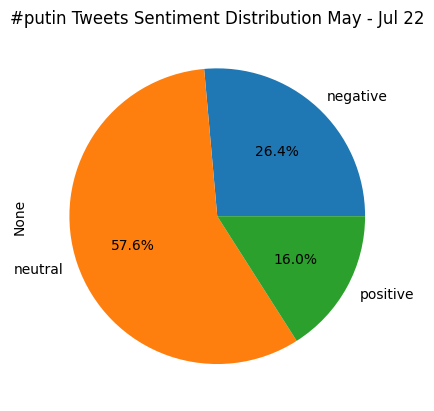

In [35]:
x=data.groupby('sentiment').size()
x.plot.pie(title="#putin Tweets Sentiment Distribution May - Jul 22",autopct='%1.1f%%')

<Axes: title={'center': 'Frequency\xa0of\xa0Sentiment\xa0per\xa0Month'}, xlabel='Date'>

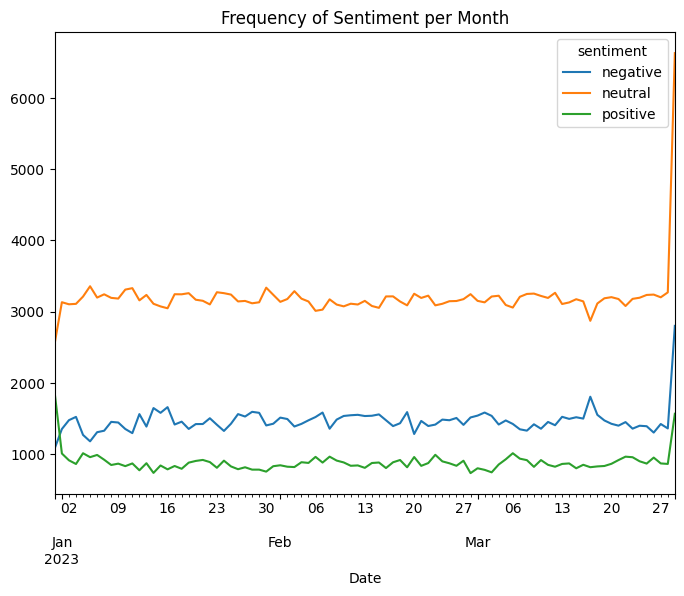

In [36]:
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
freq_per_month=data.groupby(pd.Grouper(freq='D'))['sentiment'].value_counts()
freq_per_month=freq_per_month.unstack(level='sentiment')
freq_per_month.plot(kind='line',figsize=(8,6),title='Frequency of Sentiment per Month')

# **Logistic regression for predicting labels**

In [37]:
X_ukraine['Predicted Label'] = clf.predict(X_ukraine['Tweet'])

In [38]:
print("Report for Tweets with Putin Jan to March")
print(classification_report(X_ukraine['label'],X_ukraine['Predicted Label']))

Report for Tweets with Putin Jan to March
              precision    recall  f1-score   support

           0       0.76      0.98      0.86    130742
           1       0.94      0.49      0.64     79057

    accuracy                           0.80    209799
   macro avg       0.85      0.74      0.75    209799
weighted avg       0.83      0.80      0.78    209799



# **BERTopic Modelling**

In [39]:
import nltk
from nltk.corpus import stopwords
from umap import UMAP
from bertopic import BERTopic

In [40]:
umap_model = UMAP(random_state=3231)
bert_topic_model= BERTopic(embedding_model = "all-MiniLM-L6-v2", umap_model=umap_model)

bert_negative = X_ukraine[X_ukraine['label']==0] #change this to 1 if positive. keep 0 if negative.
bert_negative = bert_negative.Tweet.tolist()
topics, probs = bert_topic_model.fit_transform(bert_negative)

In [41]:
pd.set_option('display.max_rows', None)


In [42]:
topic_list=bert_topic_model.get_topic_info()
topic_list

,Topic,Count,Name
0,-1,60249,-1_biden_trump_putin_russia
1,0,3656,0_money_tax_dollars_billion
2,1,3095,1_nato_natos_join_member
3,2,1194,2_tanks_leopard_germany_abrams
4,3,1004,3_china_chinese_chinas_xi
5,4,993,4_flag_flags_profile_bio
6,5,959,5_nuclear_nukes_nuke_tactical
7,6,939,6_video_videos_footage_photos
8,7,809,7_laundering_scheme_audit_fraud
9,8,733,8_zelensky_zelenskyy_zelenskys_zelenski


In [43]:
bert_topic_model.visualize_barchart()

In [44]:
#Positive
umap_model = UMAP(random_state=3231)
bert_topic_model= BERTopic(embedding_model = "all-MiniLM-L6-v2", umap_model=umap_model)

bert_positive = X_ukraine[X_ukraine['label']==1] #change this to 1 if positive. keep 0 if negative.
bert_positive = bert_positive.Tweet.tolist()
topics, probs = bert_topic_model.fit_transform(bert_positive)

pd.set_option('display.max_rows', None)
topic_list=bert_topic_model.get_topic_info()
topic_list

bert_topic_model.visualize_barchart()